In [81]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation

## Q-Learning:


\begin{equation*}SuttonBarto : Q(S_t,A_t)\longleftarrow Q(S_t,A_t) + \alpha[R_{t+1}+\gamma max_{a}Q(s_{t+1},a)-Q(S_t,A_t)]
\end{equation*}





In [86]:
N_ROWS = 4
N_COLS = 5
GRID_WORLD = np.zeros((N_ROWS, N_COLS))

WIN_STATE = (1,4)
GRID_WORLD[WIN_STATE] = 1

LOSE_STATE = (2,3)
GRID_WORLD[LOSE_STATE] = -50

INVALID_STATE = (1,1)
GRID_WORLD[INVALID_STATE] = -10
INVALID_STATE = (2,1)
GRID_WORLD[INVALID_STATE] = -10
INVALID_STATE = (0,3)
GRID_WORLD[INVALID_STATE] = -10

ACTIONS = ('Up', 'Down', 'Left', 'Right')

GAMMA = .9
ALPHA = 0.1
MIN_EPSILON = 0.05


class Agent():
    
    def __init__(self, initial_state):
        self.initial_state = initial_state
        self.current_state = initial_state
        self.knowledge = {(i,j): {} for i in range(N_ROWS) for j in range(N_COLS)}
                
        
    def __str__(self) -> str:
        return f'turti at {self.current_state} with knowledge {self.knowledge[self.current_state]}'
    
    
    def get_next_state(self, base_state, next_action:str)->tuple:
        if next_action == 'Up':
            new_state = (max(base_state[0]-1, 0), base_state[1])
        elif next_action == 'Down':
            new_state = (min(base_state[0]+1, N_ROWS-1), base_state[1])
        elif next_action == 'Left':
            new_state = (base_state[0], max(base_state[1]-1, 0))
        elif next_action == 'Right':
            new_state = (base_state[0], min(base_state[1]+1, N_COLS-1))
        return new_state
    
    
    def get_best_action(self, state):
        
        possible_actions = [a for a in ACTIONS if self.get_next_state(state, a) != state]
        random.shuffle(possible_actions)
        
        # 0? or the value in grid world?
        
        actions = sorted([(a, self.knowledge[state].get(a, 0)) 
                          for a in possible_actions], 
                         key=lambda x: x[1], reverse=True)
        
        return actions[0]

    
    
    def calculate_next_action_reward(self, next_state, action):
        
        if next_state==self.current_state:
            return self.knowledge[self.current_state].get(action, 0)
        
        # Current value of the state with the action
        q_a_st = self.knowledge[self.current_state].get(action, 0)
        
        # Max value possible value in the next state
        q_max_a_st1 = self.knowledge[next_state].get(self.get_best_action(next_state)[0], 0)
        
        
        q = q_a_st + ALPHA * (GRID_WORLD[next_state] + GAMMA * q_max_a_st1 - q_a_st) 
        
        return q
    
    
    def update_q_knowledge(self):
        for action in ACTIONS:
            next_state = self.get_next_state(self.current_state, action)
            if next_state == self.current_state:
                continue
            self.knowledge[self.current_state][action] = self.calculate_next_action_reward(next_state, action)

    
    def choose_greedy_action(self, epsilon):
        
        if random.random() < epsilon:
            return random.choice(ACTIONS)
        else:
            return self.get_best_action(self.current_state)[0]
    

    def restart(self):
        self.current_state = self.initial_state
        
        
    def epsilon_decay(self, t, decay_rate=0.03):
        return MIN_EPSILON + (1-MIN_EPSILON) + np.exp(-decay_rate*t)
        
            
    def move(self, t):
        
        self.update_q_knowledge()
        
        new_action = self.choose_greedy_action(epsilon=self.epsilon_decay(t))
        
        new_state = self.get_next_state(self.current_state, new_action)
        
        self.current_state = new_state
                
        if (new_state == WIN_STATE) or (new_state == LOSE_STATE):
            self.restart()
            return self.initial_state
            
        
        return new_state

In [87]:
turti = Agent(initial_state=(2,0))

for i in range(300):
    turti.move(t=i)

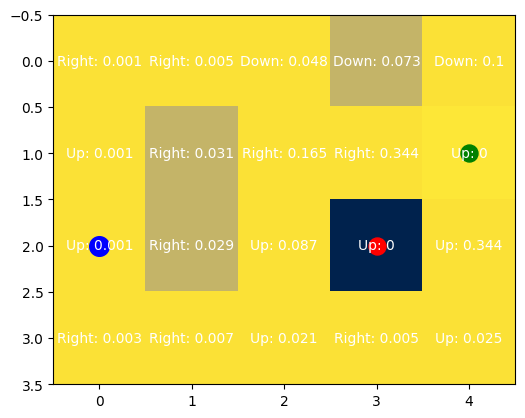

In [88]:
plt.imshow(GRID_WORLD, cmap='cividis', norm='linear')

for i in range(GRID_WORLD.shape[0]):
        for j in range(GRID_WORLD.shape[1]):
            best_action, value = turti.get_best_action((i,j))
            plt.text(j, i, f'{best_action}: {round(value, 3)}', ha='center', va='center', color='white') 

            
plt.scatter(turti.initial_state[1], turti.initial_state[0], color='b', s=200)

plt.scatter(WIN_STATE[1], WIN_STATE[0], color='g', s=150)
plt.scatter(LOSE_STATE[1], LOSE_STATE[0], color='r', s=150)

MovieWriter ffmpeg unavailable; using Pillow instead.


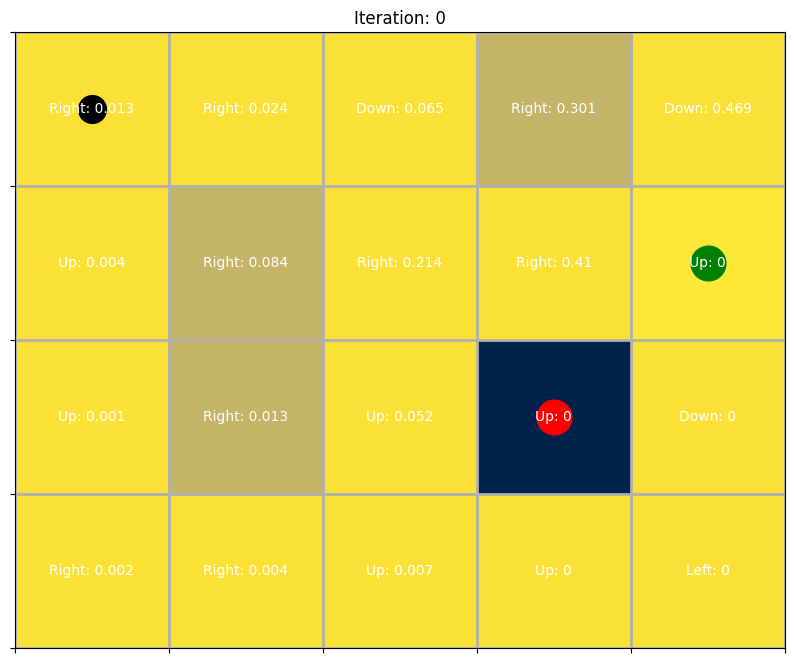

In [89]:
turti = Agent(initial_state=(2,0))

fig, ax = plt.subplots(figsize=(15, 8))

def update(ite):
    world_knowledge = GRID_WORLD.copy()
    ax.clear()
    ax.set_title(f'Iteration: {ite}')
    ax.imshow(world_knowledge, cmap='cividis')
    
    ax.set_xticks(np.arange(-.5, N_COLS, 1))
    ax.set_yticks(np.arange(-.5, N_ROWS, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.grid(which='both', linewidth=2)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    
    for i in range(world_knowledge.shape[0]):
        for j in range(world_knowledge.shape[1]):
            best_action, value = turti.get_best_action((i,j))
            ax.text(j, i, f'{best_action}: {round(value, 3)}', ha='center', va='center', color='white')        
        
    ax.plot(turti.current_state[1], turti.current_state[0], 'ko', markersize=20)
    
    ax.plot(WIN_STATE[1], WIN_STATE[0], 'go', markersize=25)
    ax.plot(LOSE_STATE[1], LOSE_STATE[0], 'ro', markersize=25)
    if ite>0:
        turti.move(t=ite)
    return ax

ani = animation.FuncAnimation(fig, update, frames=range(300))
ani.save('simulations/q_learning_v1.gif', fps=10)

In [14]:
'''
for _ in range(200):
    next_action = turti.choose_action()
    turti.move(next_action)
    
'''

'\nfor _ in range(200):\n    next_action = turti.choose_action()\n    turti.move(next_action)\n    \n'